# Packing Smaller Rectangles into a Larger One
Our task is to fill Large Rectangle with given smaller ones, I encountered this problem a few years ago when I had to write a program to optimize the packing of pallets into a truck. At the time, the task was too challenging for me. The only solution I could come up with was an ugly brute-force approach, which would not have been effective anyway. As it turns out, this is an NP-hard problem, which is even described on Wikipedia:  
[Rectangle Packing on Wikipedia](https://en.wikipedia.org/wiki/Rectangle_packing#Packing_different_rectangles_in_a_given_rectangle)

During my studies, I learned about Genetic Algorithms (GA), which are perfectly suited for this type of problem.


In [1]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

### Dataset
Dataset should consist of three elements:
- dataset[0] - width of the Large Rectangle
- dataset[1] - height of the Large Rectangle
- dataset[2] - list of pairs in format (width, height), each pair represents one smaller rectangle 

In [3]:
def get_random_dataset(room_width_low = 40, room_width_high = 60, room_height_low = 40, room_height_high = 60, num_rectangles = 30):
    ROOM_WIDTH = random.randint(room_width_low, room_width_high)
    ROOM_HEIGHT = random.randint(room_height_low, room_height_high)
    rectangles = [(random.randint(ROOM_WIDTH // 10, ROOM_WIDTH // 3), random.randint(ROOM_HEIGHT // 10, ROOM_HEIGHT // 3)) for _ in range(num_rectangles)]
    return ROOM_WIDTH, ROOM_HEIGHT, rectangles

dataset = get_random_dataset()
dataset

(57,
 45,
 [(16, 15),
  (19, 7),
  (19, 12),
  (17, 5),
  (13, 11),
  (16, 12),
  (8, 10),
  (5, 15),
  (17, 11),
  (12, 4),
  (6, 5),
  (15, 13),
  (12, 8),
  (15, 4),
  (17, 14),
  (5, 12),
  (6, 4),
  (7, 5),
  (15, 4),
  (5, 13),
  (13, 4),
  (10, 12),
  (6, 4),
  (17, 7),
  (7, 10),
  (16, 12),
  (6, 11),
  (15, 13),
  (14, 12),
  (14, 12)])

### Individual
Individual is a list of tuples, every tuple consists of 3 elements:
- chromosome[0] - order in which the rectangles will be considered (permutation of numbers from [0, n))
- chromosome[1] - determines x coordinate of rectangle placement
- chromosome[2] - 0: don't flip, 1: flip rectangle by 90 degrees

Example:<br>
ROOM_WIDTH = 50<br>
rectangle = (10, 20)<br>
chromosome = (5, 0.6, 1)<br>

chromosome[0] = 5, so it would be taken into consideration as 5th<br>
chromosome[2] = 1, so it will be flipped => rectangle = (20, 10)<br>
chromosome[1] = 0.6, it's left edge will be at x = (50 - 20) * 0.6 = 18<br>

Note, that rectangle is pushed as far as possible.

In [4]:
def create_individual(num_rectangles):
    # Initialize an individual with random positions and rotations for each rectangle
    order = [x for x in range(num_rectangles)]
    np.random.shuffle(order)
    rotation = [random.choice([0, 1]) for _ in range(num_rectangles)]
    return creator.Individual([
        (order[i], random.random(), rotation[i]) for i in range(num_rectangles)
    ])

individual = create_individual(len(dataset[2]))
individual

[(11, 0.4515455026521503, 1),
 (10, 0.2490505169450784, 0),
 (21, 0.8629033353813933, 0),
 (12, 0.08675301876468533, 1),
 (6, 0.2998481052219961, 0),
 (23, 0.9273921210922031, 1),
 (25, 0.0770431265224234, 0),
 (8, 0.08823142817719332, 0),
 (2, 0.35411050692062573, 1),
 (16, 0.9901431517272579, 0),
 (0, 0.08393734982251733, 1),
 (28, 0.20704028907410066, 1),
 (20, 0.938902382408774, 1),
 (1, 0.29474872068752556, 1),
 (17, 0.6141976924856145, 0),
 (26, 0.25169843380265355, 1),
 (4, 0.3268726571847831, 0),
 (15, 0.2405656247918978, 1),
 (9, 0.47017727737163173, 1),
 (18, 0.9589848364950255, 1),
 (29, 0.3382525622878598, 0),
 (7, 0.04104058506301289, 1),
 (13, 0.08217273982869544, 0),
 (3, 0.24805646787729552, 0),
 (14, 0.9338357857740299, 0),
 (5, 0.06920850707455684, 0),
 (27, 0.08523254493516663, 0),
 (19, 0.746908225231895, 0),
 (24, 0.9432863331199043, 0),
 (22, 0.5418368974126512, 0)]

### Evaluation
Simulation of placing rectangles as described above, as output returns total covered area, the higher the better.<br>
Simulation has to obey rules - rectangles can't overlap. It's taken care of using curr_levels, it keeps track of shape of "blocked" area.<br>
Example:<br>
'#' is a taken area<br>
"###########"<br>
"#######         "<br>
"         #######"<br>
"             ###    "<br>
(begin, width, height)<br>
curr_levels = [(0, 4, 2), (4, 2, 3), (6, 3, 4), (9, 2, 3)]<br>
If a rectangle can't be placed it's skipped.<br>
I also added a little heuristic approach - I align rectangle to closest possible edge, so it doesn't cause so much chaos.

In [5]:
def evaluate(individual, dataset):
    ROOM_WIDTH, ROOM_HEIGHT, rectangles = dataset
    curr_levels = [(0, ROOM_WIDTH, 0)] # List of (begin, width, height)
    count = 0
    total_area = 0.0
    holes = 0
    for (order, ratio, rotation) in individual:
        w, h = rectangles[order]
        if rotation == 1:
            w, h = h, w  # Rotate rectangle
        x = ratio * (ROOM_WIDTH - w)
        updated_levels = []
        inserted = False
        # print(curr_levels)
        # print(x, w, h)
        left = [(begin, begin + width) for (begin, width, height) in curr_levels if begin <= x and x < begin + width][0]
        right = [(begin, begin + width) for (begin, width, height) in curr_levels if begin < x + w and x + w <= begin + width][0]
        left_max = left[0]
        if left[1] + w <= ROOM_WIDTH and left[1] - x < x - left[0]:
            left_max = left[1]
        right_max = right[1]
        if right[0] - w >= 0 and (x + w) - right[0] < right[1] - (x + w):
            right_max = right[0]
        new_x = left_max
        if x - left_max > right_max - (x + w):
            new_x = right_max - w
        
        new_height = max([height for (begin, width, height) in curr_levels if not ((begin + width <= new_x) or (new_x + w <= begin))]) + h
        if new_height > ROOM_HEIGHT:
            continue

        for (begin, width, height) in curr_levels:
            if begin + width <= new_x:
                updated_levels.append((begin, width, height))
            elif new_x + w <= begin:
                if not inserted:
                    updated_levels.append((new_x, w, new_height))
                    inserted = True
                updated_levels.append((begin, width, height))
            elif begin < new_x:
                updated_levels.append((begin, new_x - begin, height))
                if new_x + w < begin + width:
                    updated_levels.append((new_x, w, new_height))
                    inserted = True
                    if new_height - h > height:
                        holes += 1
                    updated_levels.append((new_x + w, begin + width - (new_x + w), height))
            elif new_x + w < begin + width:
                updated_levels.append((new_x, w, new_height))
                inserted = True
                if new_height - h > height:
                    holes += 1
                updated_levels.append((new_x + w, begin + width - (new_x + w), height))
            elif new_height - h > height:
                holes += 1

        if not inserted:
            updated_levels.append((new_x, w, new_height))
        
        curr_levels = updated_levels
        count += 1
        total_area += w * h
    return total_area, #+ count * 2 + (ROOM_HEIGHT - max(height for (_, _, height) in curr_levels)) * ROOM_WIDTH / 4 - holes * 7,

def dbg_evaluate(individual, dataset):
    ROOM_WIDTH, ROOM_HEIGHT, rectangles = dataset
    curr_levels = [(0, ROOM_WIDTH, 0)] # List of (begin, width, height)
    count = 0
    total_area = 0.0
    placed_rectangles = []
    for (order, ratio, rotation) in individual:
        w, h = rectangles[order]
        if rotation == 1:
            w, h = h, w  # Rotate rectangle
        x = ratio * (ROOM_WIDTH - w)
        updated_levels = []
        inserted = False
        #print(curr_levels)
        #print(f"x={x}, w={w}, h={h}")

        left = [(begin, begin + width) for (begin, width, height) in curr_levels if begin <= x and x < begin + width][0]
        right = [(begin, begin + width) for (begin, width, height) in curr_levels if begin < x + w and x + w <= begin + width][0]
        left_max = left[0]
        if left[1] + w <= ROOM_WIDTH and left[1] - x < x - left[0]:
            left_max = left[1]
        right_max = right[1]
        if right[0] - w >= 0 and (x + w) - right[0] < right[1] - (x + w):
            right_max = right[0]
        new_x = left_max
        if x - left_max > right_max - (x + w):
            new_x = right_max - w

        new_height = max([height for (begin, width, height) in curr_levels if not ((begin + width <= new_x) or (new_x + w <= begin))]) + h
        #print(f"new_height: {new_height}, new_x: {new_x}")
        if new_height > ROOM_HEIGHT:
            continue
        for (begin, width, height) in curr_levels:
            if begin + width <= new_x:
                updated_levels.append((begin, width, height))
            elif new_x + w <= begin:
                if not inserted:
                    updated_levels.append((new_x, w, new_height))
                    inserted = True
                updated_levels.append((begin, width, height))
            elif begin < new_x:
                updated_levels.append((begin, new_x - begin, height))
                if new_x + w < begin + width:
                    updated_levels.append((new_x, w, new_height))
                    inserted = True
                    updated_levels.append((new_x + w, begin + width - (new_x + w), height))
            elif new_x + w < begin + width:
                updated_levels.append((new_x, w, new_height))
                inserted = True
                updated_levels.append((new_x + w, begin + width - (new_x + w), height))
        if not inserted:
            updated_levels.append((new_x, w, new_height))
        placed_rectangles.append((new_x, new_height - h, w, h, order))
        curr_levels = updated_levels
        count += 1
        total_area += w * h
    else:
        pass#print(curr_levels)
    #print(count, len(rectangles))
    return placed_rectangles, total_area

evaluate(individual, dataset)

(888.0,)

### Crossover
Based on my observations, I came to the conclusion that the most important element of a given solution is the first n rectangles taken into account, they shape the "terrain" and influence the next chromosomes.<br>
That is why I introduced my own method of crossing over - children receive the first n (based on order) chromosomes from their parents, rest doesn't really matter.

In [6]:
def pref_crossover(parent1, parent2):
    size = len(parent1)
    
    child1, child2 = [None]*size, [None]*size
    unused1, unused2 = set([x for x in range(size)]), set([x for x in range(size)])

    # Select prefix to crossover
    pref = random.randint(1, len(parent1))
    order_mapping1 = [None]*size
    order_mapping2 = [None]*size
    for i in range(size):
        order_mapping1[parent1[i][0]] = i
        order_mapping2[parent2[i][0]] = i
    for i in range(pref):
        unused1.remove(order_mapping1[i])
        child1[order_mapping1[i]] = parent1[order_mapping1[i]]
        unused2.remove(order_mapping2[i])
        child2[order_mapping2[i]] = parent2[order_mapping2[i]]
    common = unused1.intersection(unused2)
    for idx in common:
        child2[idx] = parent1[idx]
        child1[idx] = parent2[idx]
    unused1.difference_update(common)
    unused2.difference_update(common)
    for a, b in zip(list(unused1), list(unused2)):
        child1[a] = parent2[b]
        child2[b] = parent1[a]
    return child1, child2

parent1 = create_individual(5)
parent2 = create_individual(5)
(parent1, parent2, pref_crossover(parent1, parent2))

([(3, 0.564776613927853, 1),
  (2, 0.26541279399965234, 0),
  (0, 0.5725524413981266, 0),
  (1, 0.2106924314721197, 1),
  (4, 0.29022416763611414, 1)],
 [(0, 0.41299568135365705, 1),
  (1, 0.5704729432744747, 0),
  (4, 0.31313993222701286, 1),
  (2, 0.8127033058670317, 1),
  (3, 0.21064883193047623, 0)],
 ([(3, 0.564776613927853, 1),
   (2, 0.26541279399965234, 0),
   (0, 0.5725524413981266, 0),
   (1, 0.2106924314721197, 1),
   (4, 0.31313993222701286, 1)],
  [(0, 0.41299568135365705, 1),
   (1, 0.5704729432744747, 0),
   (4, 0.29022416763611414, 1),
   (2, 0.8127033058670317, 1),
   (3, 0.21064883193047623, 0)]))

### Mutation
I chose inversion mutation, it is supposed to help explore this broad searchspace

In [7]:
def inversion_mutation(mutant):
    idx1, idx2 = random.sample(range(len(mutant)), 2)
    if idx1 > idx2:
        idx1, idx2 = idx2, idx1
    
    while idx1 < idx2:
        mutant[idx1], mutant[idx2] = mutant[idx2], mutant[idx1]
        mutant[idx1] = (mutant[idx1][0], max(0.0, min(mutant[idx1][1] + random.random() / 2 - 0.25, 1.0)), round(abs(mutant[idx1][2] - random.random() * 0.7)))
        mutant[idx2] = (mutant[idx2][0], max(0.0, min(mutant[idx2][1] + random.random() / 2 - 0.25, 1.0)), round(abs(mutant[idx2][2] - random.random() * 0.7)))
        idx1 += 1
        idx2 -= 1
    return mutant
mutant = create_individual(5)
print(mutant)
print(inversion_mutation(mutant))

[(2, 0.9870210490133182, 1), (4, 0.948763960337188, 0), (0, 0.2890125707070571, 0), (1, 0.8296947996683781, 1), (3, 0.015094713205359822, 0)]
[(4, 0.7903979148506763, 0), (2, 1.0, 1), (0, 0.2890125707070571, 0), (1, 0.8296947996683781, 1), (3, 0.015094713205359822, 0)]


### Genetic Algorithm
Basic genetic algorithm loop:
- 0 create population
- 1 assess fitness of every individual
- 2 select mating pool (tournament method)
- 3 crossover
- 4 mutate
- 5 offspring replaces old population
- 6 go to step 1 unless stopping condition

In [8]:
def run_genetic_algorithm(dataset, POPSIZE = 500, NGEN = 600, CXPB = 0.5, MUTPB = 0.1, TRNSIZE = 20):
    toolbox = base.Toolbox()
    toolbox.register("individual", create_individual, len(dataset[2]))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evaluate, dataset=dataset)
    toolbox.register("mate", pref_crossover)
    toolbox.register("mutate", inversion_mutation)
    toolbox.register("select", tools.selTournament, tournsize=TRNSIZE)

    population = toolbox.population(n=POPSIZE)
    Y_MAX = [0] * NGEN
    Y_MEAN = [0] * NGEN
    Y_MIN = [dataset[0] * dataset[1] + 10] * NGEN
    for gen in range(NGEN):
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        for parent1, parent2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(parent1, parent2)
                del parent1.fitness.values, parent2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        population[:] = offspring
        for individual in population:
            Y_MAX[gen] = max(Y_MAX[gen], individual.fitness.values[0])
            Y_MEAN[gen] += individual.fitness.values[0] / POPSIZE
            Y_MIN[gen] = min(Y_MIN[gen], individual.fitness.values[0])

    best_individual = tools.selBest(population, 1)[0]
    return Y_MAX, Y_MEAN, Y_MIN, best_individual

Y_MAX, Y_MEAN, Y_MIN, best_individual = run_genetic_algorithm(dataset)
print(Y_MAX, Y_MEAN, Y_MIN, best_individual, sep='\n')

[2076.0, 2076.0, 2076.0, 2076.0, 2076.0, 2076.0, 2076.0, 2112.0, 2112.0, 2148.0, 2148.0, 2148.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2184.0, 2196.0, 2196.0, 2196.0, 2196.0, 2196.0, 2196.0, 2241.0, 2241.0, 2241.0, 2241.0, 2251.0, 2251.0, 2251.0, 2251.0, 2251.0, 2251.0, 2251.0, 2251.0, 2251.0, 2251.0, 2251.0, 2251.0, 2294.0, 2294.0, 2294.0, 2294.0, 2294.0, 2294.0, 2294.0, 2294.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2318.0, 2324.0, 2324.0, 2324.0, 2324.0, 2324.0, 2324.0, 2327.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0, 2368.0,

### Assesment of GA approach
In order to adjust parameters we can sketch a graph of progress

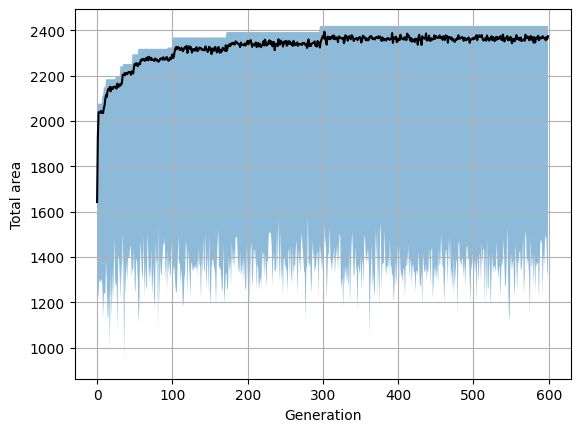

In [9]:
def plot_convergence(plt, Y_MIN, Y_MEAN, Y_MAX):
    fig, ax = plt.subplots(1, 1)
    X = [x for x in range(len(Y_MIN))]
    ax.fill_between(X, Y_MIN, Y_MAX, alpha=0.5)
    ax.plot(X, Y_MEAN, linestyle='-', color="black")
    plt.xlabel('Generation')
    plt.ylabel('Total area')
    plt.grid(True)
plot_convergence(plt, Y_MIN, Y_MEAN, Y_MAX)

#### Problem of GA
Genetic Algorithms really depend on random seed (initial population), so in order to get best solution it is advised to run it tens of times.

Run number 1
Run number 2
Run number 3
Run number 4
Run number 5
Run number 6
Run number 7
Run number 8
Run number 9
Run number 10


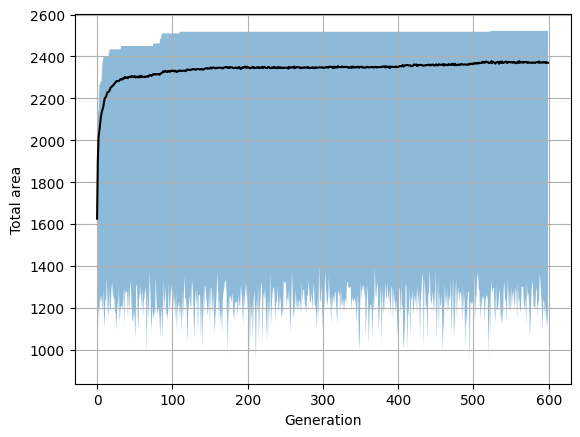

In [10]:
def average_from_mult_run(dataset, num_of_runs = 10, POPSIZE = 500, NGEN = 600, CXPB = 0.5, MUTPB = 0.1, TRNSIZE = 20):
    Y_MAXs = [0] * NGEN
    Y_MEANs = [0] * NGEN
    Y_MINs = [dataset[0] * dataset[1] + 10] * NGEN
    best_individuals = None
    for i in range(num_of_runs):
        print(f"Run number {i + 1}")
        Y_MAX, Y_MEAN, Y_MIN, best_individual = run_genetic_algorithm(dataset, POPSIZE, NGEN, CXPB, MUTPB, TRNSIZE)
        for gen in range(NGEN):
            Y_MAXs[gen] = max(Y_MAXs[gen], Y_MAX[gen])
            Y_MEANs[gen] += Y_MEAN[gen] / num_of_runs
            Y_MINs[gen] = min(Y_MINs[gen], Y_MIN[gen])
        if Y_MAXs[-1] == Y_MAX[-1]:
            best_individuals = best_individual
    return Y_MAXs, Y_MEANs, Y_MINs, best_individuals

Y_MAX, Y_MEAN, Y_MIN, best_individual = average_from_mult_run(dataset)
plot_convergence(plt, Y_MIN, Y_MEAN, Y_MAX)

### Visualization - That's what we were waiting for!

Covered area: 2522.0 / 2565


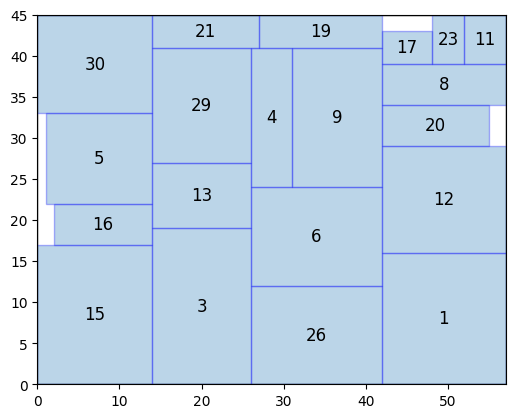

In [11]:
def visualize_individual(plt, individual, dataset):
    placed_rectangles, area = dbg_evaluate(individual, dataset)
    print(f"Covered area: {area} / {dataset[0] * dataset[1]}")
    ROOM_WIDTH, ROOM_HEIGHT = dataset[0:2]
    fig, ax = plt.subplots()
    ax.add_patch(patches.Rectangle((0, 0), ROOM_WIDTH, ROOM_HEIGHT, edgecolor='black', fill=False))
    for (x, y, w, h, id) in placed_rectangles:
        ax.add_patch(patches.Rectangle((x, y), w, h, edgecolor='blue', fill=True, alpha=0.3))
        center_x = x + w / 2
        center_y = y + h / 2
        ax.text(center_x, center_y, id + 1, ha='center', va='center', color='black', fontsize=12)
        
    ax.set_xlim(0, ROOM_WIDTH)
    ax.set_ylim(0, ROOM_HEIGHT)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    
visualize_individual(plt, best_individual, dataset)